[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1L-n0ggvlCNWXdGGs8ENKTHGwy41A_YcT)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


# Introduction

This Notebook was intended to get semi-automatically multi-spectral images of reduced size which could be used at entry of Neural network for green (vegetation) areas detection.

We need as first step images with full urban areas or full vegetation areas. This is why we need to crop images to get only reduced images with the area of interest.

Before running this Jupyter notebook, I searched the GPS coordinates of a dense urban area on OpenStreetMap -> Export
. 
In the Notebook, we create a shapefile, make a query on Copernicus hub with Sentinel API to get a corresponding satellite file. At the end we crop all bands of satellite image corresponding to the shapefile over the area of interest. These images still contain the metadata information to locate the images on a map (with folium for instance).

The same procedure must be repeated for a dense green area.

The area of interest is a rectangle, but we could create more complex shapes with holes, etc.

# Create shapefile over area of interest

https://pypi.org/project/pyshp/#writing-shapefiles


Adding a Polygon shape

Similarly to LineString, Polygon shapes consist of multiple polygons, and must be given as a list of polygons. The main difference is that polygons must have at least 4 points and the last point must be the same as the first. It's also okay if you forget to repeat the first point at the end; PyShp automatically checks and closes the polygons if you don't.

It's important to note that for Polygon shapefiles, your polygon coordinates must be ordered in a clockwise direction. If any of the polygons have holes, then the hole polygon coordinates must be ordered in a counterclockwise direction. The direction of your polygons determines how shapefile readers will distinguish between polygon outlines and holes.

>>>w = shapefile.Writer('shapefiles/test/polygon')

>>>w.field('name', 'C')

>>>w.poly([
>>>...	        [[113,24], [112,32], [117,36], [122,37], [118,20]], # poly 1

>>>...	        [[116,29],[116,26],[119,29],[119,32]], # hole 1

>>>...         [[15,2], [17,6], [22,7]]  # poly 2

>>>...        ])
>>>w.record('polygon1')

>>>w.close()

The Python Shapefile Library (PyShp) reads and writes ESRI Shapefiles in pure Python

In [ ]:
!pip install pyshp

     |████████████████████████████████| 225kB 12.5MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=3e8a99aef8d03b184a93f56a21dc1aa61119a2e69793fc956cc5adf9184bbc00
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp


In [ ]:
import shapefile

To create a shapefile you begin by initiating a new Writer instance, passing it the file path and name to save to:


In [ ]:
w = shapefile.Writer('Puebla_shapefile')
w.field('urban', 'C')

Here we create a simple polygon shapefile, which is a square composed of GPS coordinates (latitude, longitude) in clockwise order. Latitude and longitude of area of interest can be found with OpenStreetMap -> Export

In [ ]:
w.poly([ [[-98.22, 19.05], [-98.19, 19.05], [-98.19, 19.02], [-98.22, 19.02]]  ])
w.record('polygon1')

w.close()

# Visualise area of interest with geopandas and folium

https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b

In [ ]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 


     |████████████████████████████████| 19.1MB 1.2MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 0s (17.7 MB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160975 files and directories curre

In [ ]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

Read shapefile with Geopandas and visualize it with Folium python library.

In [ ]:
Puebla_shape = gpd.read_file('Puebla_shapefile.shp')
Puebla_shape

,urban,geometry
0,polygon1,"POLYGON ((-98.22000 19.05000, -98.19000 19.050..."


We need to specify the CRS: Coordinate Reference System with an EPSG code, otherwise the shapefile is unusable.

**EPSG** stands for European Petroleum Survey Group and is an organization that maintains a geodetic parameter database with standard codes, the EPSG codes, for coordinate systems, datums, spheroids, units... 

Common EPSG codes (Source: Wikipedia)

**EPSG:4326** - WGS 84, latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System among others.

**EPSG:3857** - Web Mercator projection used for display by many web-based mapping tools, including Google Maps and OpenStreetMap.

**EPSG:7789** - International Terrestrial Reference Frame 2014 (ITRF2014), an Earth-fixed system that is independent of continental drift.

In [ ]:
Puebla_shape.crs = {'init':"epsg:4326"}


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
m = folium.Map([19.050,-98.220], zoom_start=11)

folium.GeoJson(Puebla_shape).add_to(m)
m

Create a footprint from the shapefile geometry. Here we will use Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, Sentinelsat provides a handy way to convert your data into a proper format in the query).

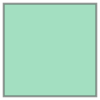

In [ ]:
footprint = None
for i in Puebla_shape['geometry']:
    footprint = i
    
footprint

# Download satellite file corresponding to footprint with Sentinel API

Before we are able to use sentinelsat, we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [ ]:
user = 'cstehle' 
password = 'mdpCopernicus01' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

Run a query for Sentinel-2 images with Level 2A with cloud coverage between 0 and 2 % that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20210201' and '20210228' (For reference on valid search queries please refer to [scihub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)).

In [ ]:
products = api.query(footprint,
                     date = ('20210201', '20210228'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,2))

We get a dictionary of all products available in this period with the query specification.

In [ ]:
# Check number of products from the query
len(products)

3

From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [ ]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,generationdate,orbitnumber,relativeorbitnumber,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage,cloudcoverpercentage,illuminationazimuthangle,illuminationzenithangle,level1cpdiidentifier,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,datastripidentifier,granuleidentifier,uuid,geometry
08f14c49-1dc0-436e-aeb2-049c0e00d1bd,S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-25T17:02:51.024Z, Instrument: MS...",false,2021-02-25 17:02:51.024,2021-02-25 17:02:51.024,2021-02-26 10:55:03.248,2021-02-25 21:19:01,29667,69,19.473588,79.018289,0.196018,0.434262,0.030630,0.053381,0.0,0.084011,140.346878,35.646974,S2A_OPER_MSI_L1C_TL_VGS2_20210225T204727_A0296...,SAFE,02.14,Sentinel-2,S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_2...,Multi-Spectral Instrument,MSI,1.12 GB,GS2A_20210225T170251_029667_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_2...,S2A_OPER_MSI_L2A_DS_VGS2_20210225T211901_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20210225T211901_A0296...,08f14c49-1dc0-436e-aeb2-049c0e00d1bd,"MULTIPOLYGON (((-97.95761 18.90121, -97.95129 ..."
55b4635e-6b82-4f9c-8151-1fcc118ba51e,S2A_MSIL2A_20210205T170501_N0214_R069_T14QNG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-05T17:05:01.024Z, Instrument: MS...",false,2021-02-05 17:05:01.024,2021-02-05 17:05:01.024,2021-02-05 21:52:12.282,NaT,29381,69,21.988162,76.164275,0.195799,0.608568,0.037498,0.064894,0.0,0.102392,NaN,NaN,S2A_OPER_MSI_L1C_TL_VGS1_20210205T191317_A0293...,SAFE,02.14,Sentinel-2,S2A_MSIL2A_20210205T170501_N0214_R069_T14QNG_2...,Multi-Spectral Instrument,MSI,1.12 GB,GS2A_20210205T170501_029381_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20210205T170501_N0214_R069_T14QNG_2...,NaN,NaN,55b4635e-6b82-4f9c-8151-1fcc118ba51e,"MULTIPOLYGON (((-97.95761 18.90121, -97.95129 ..."
a17d992e-3cf7-47e1-ae31-506a0eda3d9c,S2B_MSIL2A_20210220T170329_N0214_R069_T14QNG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-20T17:03:29.024Z, Instrument: MS...",false,2021-02-20 17:03:29.024,2021-02-20 17:03:29.024,2021-02-21 02:35:26.929,2021-02-20 21:01:47,20687,69,19.487342,78.700250,0.210208,0.517679,0.059940,0.084339,0.0,0.144280,141.961388,37.224762,S2B_OPER_MSI_L1C_TL_EPAE_20210220T202703_A0206...,SAFE,02.14,Sentinel-2,S2B_MSIL2A_20210220T170329_N0214_R069_T14QNG_2...,Multi-Spectral Instrument,MSI,1.12 GB,GS2B_20210220T170329_020687_N02.14,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_MSIL2A_20210220T170329_N0214_R069_T14QNG_2...,S2B_OPER_MSI_L2A_DS_EPAE_20210220T210147_S2021...,S2B_OPER_MSI_L2A_TL_EPAE_20210220T210147_A0206...,a17d992e-3cf7-47e1-ae31-506a0eda3d9c,"MULTIPOLYGON (((-97.95761 18.90121, -97.95129 ..."


Download image of interest

In [ ]:
api.download("08f14c49-1dc0-436e-aeb2-049c0e00d1bd	")

In [ ]:
!unzip S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.zip 

In [ ]:
pwd

'/content/drive/My Drive'

## Select bands of interest and create multiband image (RGB.tiff)

In [ ]:
ls S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.SAFE/GRANULE/L2A_T14QNG_A029667_20210225T171532/IMG_DATA/R10m/

T14QNG_20210225T170251_AOT_10m.jp2  T14QNG_20210225T170251_B08_10m.jp2
T14QNG_20210225T170251_B02_10m.jp2  T14QNG_20210225T170251_TCI_10m.jp2
T14QNG_20210225T170251_B03_10m.jp2  T14QNG_20210225T170251_WVP_10m.jp2
T14QNG_20210225T170251_B04_10m.jp2


Let's work only on 10 bands resolution to start.
We'll have to deal with different resolution bands later...

In [ ]:
# Open Bands 8, 4, 3 and 2 with Rasterio
R10 = 'S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.SAFE/GRANULE/L2A_T14QNG_A029667_20210225T171532/IMG_DATA/R10m/'

b8 = rio.open(R10+'/T14QNG_20210225T170251_B08_10m.jp2')
b4 = rio.open(R10+'/T14QNG_20210225T170251_B04_10m.jp2')
b3 = rio.open(R10+'/T14QNG_20210225T170251_B03_10m.jp2')
b2 = rio.open(R10+'/T14QNG_20210225T170251_B02_10m.jp2')

In [ ]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

In [ ]:
with rio.open('RGB_Puebla.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as dst:
    dst.write(b2.read(1),1) 
    dst.write(b3.read(1),2) 
    dst.write(b4.read(1),3) 
    dst.close()

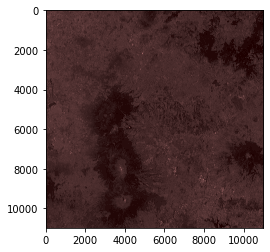

In [ ]:
# Plot first band of RGB image
src = rasterio.open("RGB_Puebla.tiff")
plt.imshow(src.read(1), cmap='pink')
plt.show()

In [ ]:
ls S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.SAFE/GRANULE/L2A_T14QNG_A029667_20210225T171532/IMG_DATA/R20m/

T14QNG_20210225T170251_AOT_20m.jp2  T14QNG_20210225T170251_B11_20m.jp2
T14QNG_20210225T170251_B02_20m.jp2  T14QNG_20210225T170251_B12_20m.jp2
T14QNG_20210225T170251_B03_20m.jp2  T14QNG_20210225T170251_B8A_20m.jp2
T14QNG_20210225T170251_B04_20m.jp2  T14QNG_20210225T170251_SCL_20m.jp2
T14QNG_20210225T170251_B05_20m.jp2  T14QNG_20210225T170251_TCI_20m.jp2
T14QNG_20210225T170251_B06_20m.jp2  T14QNG_20210225T170251_WVP_20m.jp2
T14QNG_20210225T170251_B07_20m.jp2


In [ ]:
# Open Bands 5, 6 and 7, 8A, 11, 12 with Rasterio
R20 = 'S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.SAFE/GRANULE/L2A_T14QNG_A029667_20210225T171532/IMG_DATA/R20m/'

b5 = rio.open(R20+'/T14QNG_20210225T170251_B05_20m.jp2')
b6 = rio.open(R20+'/T14QNG_20210225T170251_B06_20m.jp2')
b7 = rio.open(R20+'/T14QNG_20210225T170251_B07_20m.jp2')
b8A = rio.open(R20+'/T14QNG_20210225T170251_B8A_20m.jp2')
b11 = rio.open(R20+'/T14QNG_20210225T170251_B11_20m.jp2')
b12 = rio.open(R20+'/T14QNG_20210225T170251_B12_20m.jp2')

In [ ]:
b5.count, b5.width, b5.height

(1, 5490, 5490)

# Mask Satellite images

In [ ]:
# Check what is the crs of the file to mask
src = rasterio.open("RGB_Puebla.tiff") 
src.crs

CRS.from_epsg(32614)

In [ ]:
# Change the projection 
Puebla_shape_proj = Puebla_shape.to_crs({'init': 'epsg:32614'})
Puebla_shape_proj

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,urban,geometry
0,polygon1,"POLYGON ((582072.373 2106542.204, 585229.166 2..."


In [ ]:
# Crop RGB image
with rio.open("RGB_Puebla.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, Puebla_shape_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_Puebla_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

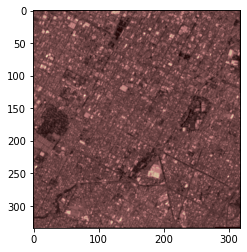

In [ ]:
# Plot first band of RGB image
src = rasterio.open("RGB_Puebla_masked.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()

In [ ]:
b2.crs

CRS.from_epsg(32614)

In [ ]:
# Crop single band image
out_image, out_transform = rio.mask.mask(b2, Puebla_shape_proj.geometry,crop=True)
out_meta = b2.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("b2_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# Loop to crop all single bands images
for (band, bandchar) in zip((b2, b3, b4, b5, b6, b7, b8, b8A, b11, b12), ("b2", "b3", "b4", "b5", "b6", "b7", "b8", "b8A", "b11", "b12")):
  out_image, out_transform = rio.mask.mask(band, Puebla_shape_proj.geometry,crop=True)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(bandchar+"_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

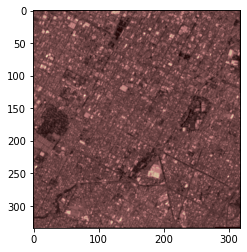

In [ ]:
# Plot croped single-band image
src = rasterio.open("b2_masked.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()

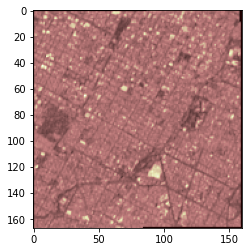

In [ ]:
# Plot croped single-band image (20m resolution)
src = rasterio.open("b5_masked.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()

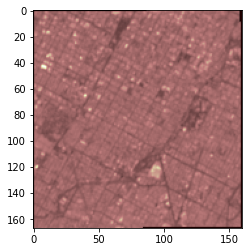

In [ ]:
# Plot croped single-band image (20m resolution)
src = rasterio.open("b11_masked.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()